# 2) Analyze source collection and target file

This notebook includes the code to analyze the collection of sounds compiled in the previous notebook and that will be later used as the source collection in our audio mosaicing code. The notebook also contains the code to analyze the target audio file that will be later reconstructed using sound chunks from the source collection.

The audio analysis carried out in this notebook uses the Pythonn bindings of the Essentia library which was introduced in the first session of AMPLAB. Please make sure you checked the [Essentia Python tutorial](https://essentia.upf.edu/documentation/essentia_python_tutorial.html) to get familiarized with using Essentia in Python. Also useful is to always have a browser tab opened with Essentia's [Algorithms Reference](https://essentia.upf.edu/documentation/algorithms_reference.html) documentation page.

In [ ]:
'''
# Essentia
!pip install essentia
# Freesound-python
!pip install git+https://github.com/mtg/freesound-python.git
# Mount drive and cd to notebook folder
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/SMC/AMPLab2324/AMPLAB 2024 Freesound session'
'''

In [27]:
import pandas as pd
import essentia
import essentia.standard as estd
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import numpy as np

In [18]:
FILES_DIR = 'files'  # Place where to store the downloaded diles. Will be relative to the current folder.
FREESOUND_STORE_METADATA_FIELDS = ['id', 'name', 'username', 'previews', 'license', 'tags']  # Freesound metadata properties to store
LEAD_SOUNDS_DIR = 'files/lead_sounds'  # Place where to store the lead sounds. Will be relative to the current folder.
LEAD_SOUNDS_METADATA_FILENAME = 'lead_sounds_metadata.csv'  # File where we'll store the metadata of our lead sounds collection
BASS_SOUNDS_DIR = 'files/bass_sounds'  # Place where to store the bass sounds. Will be relative to the current folder.
BASS_SOUNDS_METADATA_FILENAME = 'bass_sounds_metadata.csv'  # File where we'll store the metadata of our bass sounds collection
AMB_SOUNDS_DIR = 'files/amb_sounds'  # Place where to store the amb sounds. Will be relative to the current folder.
AMB_SOUNDS_METADATA_FILENAME = 'amb_sounds_metadata.csv'  # File where we'll store the metadata of our amb sounds collection

LEAD_DATAFRAME_SOURCE_FILENAME = 'lead_dataframe_source.csv'  # DataFrame file where to store the results of our analysis
BASS_DATAFRAME_SOURCE_FILENAME = 'bass_dataframe_source.csv'  # DataFrame file where to store the results of our analysis
AMB_DATAFRAME_SOURCE_FILENAME = 'amb_dataframe_source.csv'  # DataFrame file where to store the results of our analysis


In [38]:
# Define here our sound analysis function
# NOTE: remember that if you update this function and want to run a new analysis you'll need to re-run both
# this cell and the cells below that carry out the audio analysis and that call the analysis function.
# After analyzing the source collection or the target file, make sure to correct descriptors have been
# extracted by checking the DataFrame contents. DataFrame contents can be printed on screen as a table
# using 'display(data_frame_object)'

loudness_algo = estd.Loudness()
centroid_algo = estd.SpectralCentroidTime()
envelope_algo = estd.Envelope()
attack_time_algo = estd.LogAttackTime()

def analyze_sound(audio_path, frame_size=None, audio_id=None, sync_with_beats=False):
    """Analyze the audio file given in 'sound_path'.
    Use the parameter 'frame_size' to set the size of the chunks in which the audio will
    be split for analysis. If no frame_size is given, the whole audio will be analyzed as
    a single frame.
    Use the 'audio_id' parameter to pass a custom identifier for the audio that will be
    included in the analysis results. This can be useful to later identify to which file an analysis belongs.
    """
    analysis_output = []  # Here we'll store the analysis results for each chunk (frame) of the audio file

    # Load audio file
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()

    # Some processing of frame_size parameter to avoid later problems
    if frame_size is None:
        frame_size = len(audio)  # If no frame_size is given use no frames (analyze all audio at once)
    if frame_size % 2 != 0:
        frame_size = frame_size + 1 # Make frame size even

    # Calculate the start and end samples for each equally-spaced audio frame
    if sync_with_beats:
      # add zeros at the beginning of the target audio array
      extra_zeros = np.zeros(44100)
      target_audio_aug = np.append(extra_zeros, audio)
      beat_tracker_algo = estd.BeatTrackerMultiFeature()
      beat_positions, _ = beat_tracker_algo(target_audio_aug)
      # subtract one from each value in target_onsets
      target_onsets = [x - 1 for x in beat_positions]
      if target_onsets[0] < 0:
          target_onsets[0] = 0
      beat_positions = [int(round(position * 44100)) for position in target_onsets]
      beat_length = beat_positions[-1] - beat_positions[-2]
      frame_start_end_samples = zip(beat_positions[:-1], beat_positions[1:])
    else:
      frame_start_samples = range(0, len(audio), frame_size)
      frame_start_end_samples = zip(frame_start_samples[:-1], frame_start_samples[1:])

    # Iterate over audio frames and analyze each one
    for count, (fstart, fend) in enumerate(frame_start_end_samples):

        # Get corresponding audio chunk and initialize dictionary to sotre analysis results with some basic metadata
        frame = audio[fstart:fend]
        frame_output = {
            'freesound_id': audio_id,
            'id': '{0}_f{1}'.format(audio_id, count),
            'path': audio_path,
            'start_sample': fstart,
            'end_sample': fend,
        }

        # Extract loudness
        loudness = loudness_algo(frame)
        frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame

        # Extract Spectral Centroid
        centroid = centroid_algo(frame)
        frame_output['centroid'] = centroid

        # Extract Log Attack Time
        envelope = envelope_algo(frame)
        attack_time, _, _ = attack_time_algo(envelope)
        frame_output['attack_time'] = attack_time

        # Add frame analysis results to output
        analysis_output.append(frame_output)

    if sync_with_beats:
        return analysis_output, beat_length
    else:
        return analysis_output


## Analyze the target sound file

The target sound file is the following:
Beat 90 Loop 5.wav by Spol -- https://freesound.org/s/78064/ -- License: Attribution 3.0

Analyzing target sound 78064__spol__beat-90-loop-5.wav


[   INFO   ] Warning: essentia can currently only accept numpy arrays of dtype "single". "signal" dtype is double. Precision will be automatically truncated into "single".


Saved target dataframe with 16 entries! dataframe_target.csv


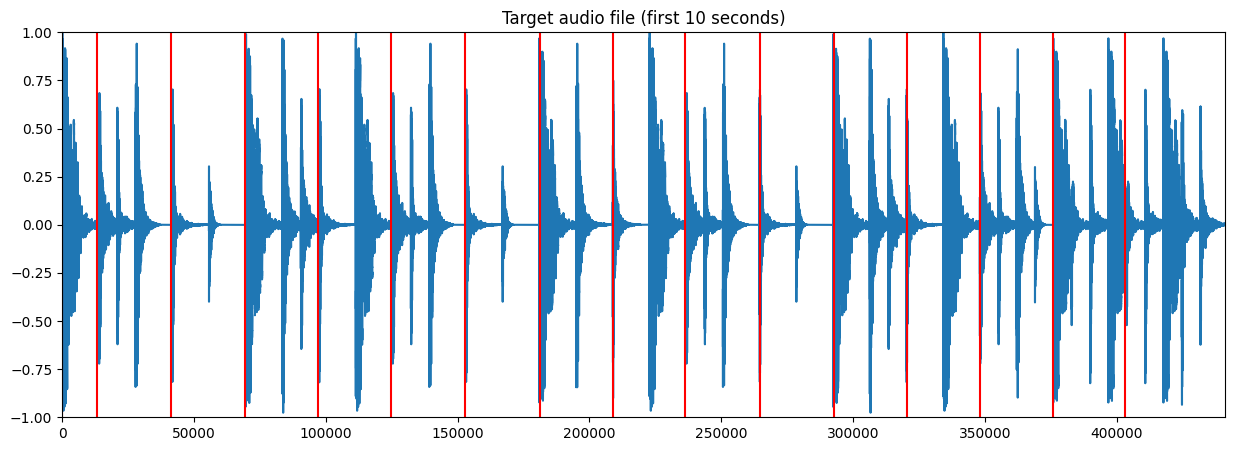

,freesound_id,id,path,start_sample,end_sample,loudness,centroid,attack_time
0,None,None_f0,78064__spol__beat-90-loop-5.wav,0,13244,0.007794,894.998413,-1.492456
1,None,None_f1,78064__spol__beat-90-loop-5.wav,13244,41404,0.001365,3218.354736,-0.495497
2,None,None_f2,78064__spol__beat-90-loop-5.wav,41404,69564,0.000521,5108.957031,-2.086931
3,None,None_f3,78064__spol__beat-90-loop-5.wav,69564,97212,0.004258,1379.817139,-1.483670
4,None,None_f4,78064__spol__beat-90-loop-5.wav,97212,124860,0.003856,1228.524780,-0.467104
5,None,None_f5,78064__spol__beat-90-loop-5.wav,124860,153020,0.001365,3218.678467,-0.495558
6,None,None_f6,78064__spol__beat-90-loop-5.wav,153020,181180,0.000676,4734.448730,-2.007951
7,None,None_f7,78064__spol__beat-90-loop-5.wav,181180,208828,0.003899,1394.155029,-1.553828
8,None,None_f8,78064__spol__beat-90-loop-5.wav,208828,236476,0.003864,1193.192627,-0.466671
9,None,None_f9,78064__spol__beat-90-loop-5.wav,236476,264636,0.001375,3296.445312,-0.495558


beat length: 28160


In [41]:
TARGET_SOUND_PATH = '78064__spol__beat-90-loop-5.wav'  # Filename of the target audio we'll reconstruct
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target.csv'  # DataFrame file where to store the analysis results of the target audio

# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH))
target_analysis, beat_length = analyze_sound(TARGET_SOUND_PATH, frame_size=2048, sync_with_beats=True)  # Also split audio in chunks of 8192 samples (~185ms)
df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME))

# Plot target audio file waveform and show ticks at the start samples of the chunks
plt.figure(figsize=(15,5))
audio = estd.MonoLoader(filename=TARGET_SOUND_PATH)()
plt.plot(audio)
plt.vlines(df_target['start_sample'].values, -1, 1, color='red')
plt.axis([0, min(len(audio), 44100 * 10), -1, 1])
plt.title('Target audio file (first 10 seconds)')
plt.show()

# play the target audio
display(Audio(TARGET_SOUND_PATH))


display(df_target)  # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame

print('beat length:', beat_length)

## Set Different Beat Lengths for Lead, Bass and Ambience

In [44]:
beat_length_lead = beat_length//2
beat_length_bass = int(beat_length*2)
beat_length_amb = int(beat_length*8)

## Analyze source collection - LEAD sounds

In [45]:
# Load the DataFrame of the lead sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(LEAD_SOUNDS_METADATA_FILENAME), index_col=0)
analyses = []
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    try:
      analysis_output = analyze_sound(sound['path'], frame_size=beat_length_lead, audio_id=sound['freesound_id'])  # Split audio in chunks of 8192 samples (~185ms)
      analyses += analysis_output
    except RuntimeError:
      continue

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(LEAD_DATAFRAME_SOURCE_FILENAME)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), LEAD_DATAFRAME_SOURCE_FILENAME))

display(df_source)  # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

Analyzing sound with id 100981 [1/64]
Analyzing sound with id 341507 [2/64]
Analyzing sound with id 256886 [3/64]
Analyzing sound with id 121231 [4/64]
Analyzing sound with id 420717 [5/64]
Analyzing sound with id 2821 [6/64]
Analyzing sound with id 593385 [7/64]
Analyzing sound with id 575304 [8/64]
Analyzing sound with id 244988 [9/64]
Analyzing sound with id 510190 [10/64]
Analyzing sound with id 342161 [11/64]
Analyzing sound with id 607888 [12/64]
Analyzing sound with id 507263 [13/64]
Analyzing sound with id 581313 [14/64]
Analyzing sound with id 9325 [15/64]
Analyzing sound with id 338277 [16/64]
Analyzing sound with id 168439 [17/64]
Analyzing sound with id 513709 [18/64]
Analyzing sound with id 509293 [19/64]
Analyzing sound with id 535947 [20/64]
Analyzing sound with id 531540 [21/64]
Analyzing sound with id 498387 [22/64]
Analyzing sound with id 170818 [23/64]
Analyzing sound with id 170811 [24/64]
Analyzing sound with id 578884 [25/64]
Analyzing sound with id 76634 [26/64]


,freesound_id,id,path,start_sample,end_sample,loudness,centroid,attack_time
0,100981,100981_f0,files/lead_sounds/100981_1234256-hq.ogg,0,14080,0.005690,1115.056396,-0.687262
1,100981,100981_f1,files/lead_sounds/100981_1234256-hq.ogg,14080,28160,0.003231,1255.118530,-0.941233
2,100981,100981_f2,files/lead_sounds/100981_1234256-hq.ogg,28160,42240,0.003210,1415.093872,-1.039457
3,341507,341507_f0,files/lead_sounds/341507_5871007-hq.ogg,0,14080,0.000023,1294.993652,-0.795695
4,341507,341507_f1,files/lead_sounds/341507_5871007-hq.ogg,14080,28160,0.000043,1200.168579,-1.066717
...,...,...,...,...,...,...,...,...
206,241520,241520_f2,files/lead_sounds/241520_950925-hq.ogg,28160,42240,0.012419,2112.174072,-1.401401
207,241520,241520_f3,files/lead_sounds/241520_950925-hq.ogg,42240,56320,0.010269,1892.945801,-0.747252
208,241520,241520_f4,files/lead_sounds/241520_950925-hq.ogg,56320,70400,0.004454,1853.548096,-1.120432
209,241528,241528_f0,files/lead_sounds/241528_950925-hq.ogg,0,14080,0.005280,588.804749,-0.914464


,freesound_id,start_sample,end_sample,loudness,centroid,attack_time
count,211.000000,211.000000,211.000000,2.110000e+02,211.000000,211.000000
mean,328355.720379,20819.715640,34899.715640,2.768935e-03,2103.215392,-1.031356
std,212212.721926,18705.846652,18705.846652,3.212656e-03,1600.537290,0.356673
min,1792.000000,0.000000,14080.000000,4.301196e-07,146.260956,-2.045648
25%,152911.000000,0.000000,14080.000000,3.934594e-04,912.905853,-1.285780
50%,257860.000000,14080.000000,28160.000000,1.840716e-03,1645.051270,-0.969669
75%,531540.000000,28160.000000,42240.000000,3.401074e-03,2908.697144,-0.743174
max,698965.000000,70400.000000,84480.000000,1.754663e-02,7596.872070,-0.516654


## Analyze source collection - BASS sounds

In [46]:
# Load the DataFrame of the bass sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(BASS_SOUNDS_METADATA_FILENAME), index_col=0)
analyses = []
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    try:
      analysis_output = analyze_sound(sound['path'], frame_size=beat_length_bass, audio_id=sound['freesound_id'])  # Split audio in chunks of 8192 samples (~185ms)
      analyses += analysis_output
    except RuntimeError:
      continue

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(BASS_DATAFRAME_SOURCE_FILENAME)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), BASS_DATAFRAME_SOURCE_FILENAME))

display(df_source)  # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

Analyzing sound with id 17011 [1/62]
Analyzing sound with id 257023 [2/62]
Analyzing sound with id 185837 [3/62]
Analyzing sound with id 72106 [4/62]
Analyzing sound with id 717119 [5/62]
Analyzing sound with id 696732 [6/62]
Analyzing sound with id 510074 [7/62]
Analyzing sound with id 510075 [8/62]
Analyzing sound with id 510076 [9/62]
Analyzing sound with id 510078 [10/62]
Analyzing sound with id 510083 [11/62]
Analyzing sound with id 424986 [12/62]
Analyzing sound with id 383437 [13/62]
Analyzing sound with id 511884 [14/62]
Analyzing sound with id 511880 [15/62]
Analyzing sound with id 511882 [16/62]
Analyzing sound with id 510077 [17/62]
Analyzing sound with id 511885 [18/62]
Analyzing sound with id 506302 [19/62]
Analyzing sound with id 433663 [20/62]
Analyzing sound with id 546528 [21/62]
Analyzing sound with id 437687 [22/62]
Analyzing sound with id 72894 [23/62]
Analyzing sound with id 148957 [24/62]
Analyzing sound with id 120484 [25/62]
Analyzing sound with id 418488 [26/62

,freesound_id,id,path,start_sample,end_sample,loudness,centroid,attack_time
0,17011,17011_f0,files/bass_sounds/17011_57789-hq.ogg,0,56320,0.000086,1222.708496,-0.426902
1,185837,185837_f0,files/bass_sounds/185837_967820-hq.ogg,0,56320,0.000098,635.151245,-0.607132
2,72106,72106_f0,files/bass_sounds/72106_448953-hq.ogg,0,56320,0.001539,4349.799316,-0.741349
3,72106,72106_f1,files/bass_sounds/72106_448953-hq.ogg,56320,112640,0.000496,4865.911621,-0.995299
4,72106,72106_f2,files/bass_sounds/72106_448953-hq.ogg,112640,168960,0.000087,967.741882,-1.364544
...,...,...,...,...,...,...,...,...
97,722273,722273_f1,files/bass_sounds/722273_15555277-hq.ogg,56320,112640,0.000375,873.832092,-0.983384
98,722288,722288_f0,files/bass_sounds/722288_15555277-hq.ogg,0,56320,0.000093,968.963379,-0.512051
99,722288,722288_f1,files/bass_sounds/722288_15555277-hq.ogg,56320,112640,0.000039,914.704956,-0.833534
100,722296,722296_f0,files/bass_sounds/722296_15555277-hq.ogg,0,56320,0.000109,902.241455,-2.465460


,freesound_id,start_sample,end_sample,loudness,centroid,attack_time
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,483815.019608,35890.196078,92210.196078,0.001572,1572.341959,-0.786129
std,211145.362930,55357.806769,55357.806769,0.002408,1749.650116,0.521955
min,17011.000000,0.000000,56320.000000,0.000008,120.111679,-2.465460
25%,397265.000000,0.000000,56320.000000,0.000111,588.602234,-1.105991
50%,510083.000000,0.000000,56320.000000,0.000591,913.527893,-0.811240
75%,706970.000000,56320.000000,112640.000000,0.002907,1663.097351,-0.416187
max,722296.000000,281600.000000,337920.000000,0.019445,7866.880859,0.102063


## Analyze source collection - AMB sounds

In [47]:
# Load the DataFrame of the bass sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(AMB_SOUNDS_METADATA_FILENAME), index_col=0)
analyses = []
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    try:
      analysis_output = analyze_sound(sound['path'], frame_size=beat_length_amb, audio_id=sound['freesound_id'])  # Split audio in chunks of 8192 samples (~185ms)
      analyses += analysis_output
    except RuntimeError:
      continue

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(AMB_DATAFRAME_SOURCE_FILENAME)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), AMB_DATAFRAME_SOURCE_FILENAME))

display(df_source)  # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

Analyzing sound with id 419929 [1/20]
Analyzing sound with id 133761 [2/20]
Analyzing sound with id 705300 [3/20]
Analyzing sound with id 379165 [4/20]
Analyzing sound with id 86361 [5/20]
Analyzing sound with id 34066 [6/20]
Analyzing sound with id 334149 [7/20]
Analyzing sound with id 522752 [8/20]
Analyzing sound with id 85602 [9/20]
Analyzing sound with id 379246 [10/20]
Analyzing sound with id 405136 [11/20]
Analyzing sound with id 478383 [12/20]
Analyzing sound with id 691534 [13/20]
Analyzing sound with id 640117 [14/20]
Analyzing sound with id 479540 [15/20]
Analyzing sound with id 689275 [16/20]
Analyzing sound with id 58416 [17/20]
Analyzing sound with id 452684 [18/20]
Analyzing sound with id 367986 [19/20]
Analyzing sound with id 534918 [20/20]
Saved source DataFrame with 20 entries! amb_dataframe_source.csv


,freesound_id,id,path,start_sample,end_sample,loudness,centroid,attack_time
0,419929,419929_f0,files/amb_sounds/419929_8373708-hq.ogg,0,225280,1.770156e-04,3584.869141,0.165780
1,133761,133761_f0,files/amb_sounds/133761_1661766-hq.ogg,0,225280,7.605807e-04,1098.495361,-0.853239
2,705300,705300_f0,files/amb_sounds/705300_1661766-hq.ogg,0,225280,1.691630e-04,1093.820190,-0.876541
3,379165,379165_f0,files/amb_sounds/379165_7027631-hq.ogg,0,225280,9.095985e-06,1231.613647,0.238649
4,86361,86361_f0,files/amb_sounds/86361_14771-hq.ogg,0,225280,4.791234e-04,8217.247070,0.491549
5,34066,34066_f0,files/amb_sounds/34066_28216-hq.ogg,0,225280,2.681545e-05,1790.063110,0.195711
6,334149,334149_f0,files/amb_sounds/334149_5910095-hq.ogg,0,225280,2.168537e-04,4373.493652,-0.175103
7,522752,522752_f0,files/amb_sounds/522752_1648170-hq.ogg,0,225280,6.764786e-05,1420.560913,-0.186723
8,85602,85602_f0,files/amb_sounds/85602_1078663-hq.ogg,0,225280,3.638296e-05,5125.435547,0.560668
9,379246,379246_f0,files/amb_sounds/379246_7027306-hq.ogg,0,225280,6.046647e-07,3955.070801,-0.325791


,freesound_id,start_sample,end_sample,loudness,centroid,attack_time
count,20.000000,20.0,20.0,2.000000e+01,20.000000,20.000000
mean,393916.000000,0.0,225280.0,4.374163e-04,3461.952580,-0.002190
std,216752.194508,0.0,0.0,7.470836e-04,2711.141453,0.512595
min,34066.000000,0.0,225280.0,6.046647e-07,342.782684,-1.143379
25%,284052.000000,0.0,225280.0,5.907864e-05,1223.733643,-0.221490
50%,412532.500000,0.0,225280.0,1.969347e-04,2797.784180,0.180746
75%,525793.500000,0.0,225280.0,4.713010e-04,4561.479126,0.427929
max,705300.000000,0.0,225280.0,3.339605e-03,9277.843750,0.614271
